# Multi-Factor Models
- References: 
  - 因子投资方法与实践
  - Ohlson O-score: https://www.wikiwand.com/en/Ohlson_O-score#Calculation_of_the_O-score
  - Mispricing Factors.https://sci-hub.wf/10.1093/rfs/hhw107
  - global q-factor.http://global-q.org/index.html
  - Statistical analysis for factor investing,Fama-MacBeth regressions.https://thomasmartins.github.io/2022/06/27/statistical-analysis-for-factor-investing.html
  

## CAPM
- Model: $E(r_i)=r_f+\beta_i[E(r_m)-r_f]$
  - Rewrite: $E(r_i)-r_f=\beta_i[E(r_m)-r_f]$
  - $\beta$: level of asset return's sensitivity compared with the market.
    - Formula: $\beta=\frac{Cov(r_i,r_m)}{Var(r_m)}$
      - $r_i=E(r_i)-r_f$
      - $r_m=E(r_m)-r_f$
    - range of β:(-$∞$,$∞$)
    - if $\beta$<=-1: asset moves in the opposite direction to the benchmark
    - if $\beta$=0: there is <u>no correlation</u> between asset prices movement and the market benchmark  
    - if $\beta$=1: the asset and market are moving in the <u>same direction</u> by *same amount*.

In this case, we use 2017-2022 monthly Amazon stock prices and S&P500 index to estimate $\beta$.

While, for simplicity the risk free rate is so low, we just set it to zero.

In [5]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 11.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize']=[8,5]
plt.rcParams['figure.dpi']=300
import statsmodels.api as sm

In [4]:
#create some variables
riskyAsset='AMZN'
marketBenchmark='^GSPC' #S&P500
startDate='2017-01-01'
endDate='2022-12-31'

In [5]:
#download stock prices from yf
StockPrices=yf.download([riskyAsset,marketBenchmark], start=startDate,end=endDate, progress=False)

In [6]:
StockPrices.head()

Adj Close                   Close                    High  \
                 AMZN        ^GSPC       AMZN        ^GSPC       AMZN   
Date                                                                    
2017-01-03  37.683498  2257.830078  37.683498  2257.830078  37.938000   
2017-01-04  37.859001  2270.750000  37.859001  2270.750000  37.984001   
2017-01-05  39.022499  2269.000000  39.022499  2269.000000  39.119999   
2017-01-06  39.799500  2276.979980  39.799500  2276.979980  39.972000   
2017-01-09  39.846001  2268.899902  39.846001  2268.899902  40.088501   

                               Low                    Open               \
                  ^GSPC       AMZN        ^GSPC       AMZN        ^GSPC   
Date                                                                      
2017-01-03  2263.879883  37.384998  2245.129883  37.896000  2251.570068   
2017-01-04  2272.820068  37.709999  2261.600098  37.919498  2261.600098   
2017-01-05  2271.500000  38.013000  2260.449951  38.077499  2268.179932   
2017-01-06  2282.100098  38.924000  2264.060059  39.118000  2271.139893   
2017-01-09  2275.489990  39.588501  2268.899902  39.900002  2273.590088   

               Volume              
                 AMZN       ^GSPC  
Date                               
2017-01-03   70422000  3773010000  
2017-01-04   50210000  3768890000  
2017-01-05  116602000  3785080000  
2017-01-06  119724000  3342080000  
2017-01-09   68922000  3219730000

In [7]:
#data processing, take the monthly end stock prices, rename columns, calculate the simple return, and drop the missing value
simple_return=StockPrices['Adj Close'].rename(columns={riskyAsset:'asset',marketBenchmark:'market'}).resample('M').last().pct_change().dropna()

In [8]:
simple_return.head()

,asset,market
Date,,
2017-02-28,0.026182,0.037198
2017-03-31,0.049110,-0.000389
2017-04-30,0.043371,0.009091
2017-05-31,0.075276,0.011576
2017-06-30,-0.026764,0.004814


In [9]:
#beta calculation with covariance approach
covariance=simple_return.cov().iloc[0,1]

In [10]:
market_variance=simple_return.market.var()

In [11]:
beta=covariance/market_variance

In [13]:
print(beta)

1.2249147473901674


In [14]:
#build the CAPM with linear regression
y=simple_return.pop('asset') #separate the S&P500 market benchmark and AMAZ stock price by pop()
X=sm.add_constant(simple_return) #check whether after estimation, the intercept (in the case of the CAPM, also known as Jensen's alpha) is zero. 
#if the interception is positive and significant, the assumed CAPM is effecitve and true,the asset or portfolio generates abnormally high risk-adjusted returns.
# if the market is inefficient or there are some other undiscovered risk factors which should be included in the model
CAPM=sm.OLS(y, X).fit()
CAPM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  asset   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     51.67
Date:                Sun, 05 Mar 2023   Prob (F-statistic):           6.07e-10
Time:                        12:54:54   Log-Likelihood:                 88.104
No. Observations:                  71   AIC:                            -172.2
Df Residuals:                      69   BIC:                            -167.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.009      0.440      0.661      -0.013       0.021
market         1.2249      0.170      7.188      0.000       0.885       1.565
==============================================================================
Omnibus:                        1.791   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.107
Skew:                           0.166   Prob(JB):                        0.575
Kurtosis:                       3.514   Cond. No.                         20.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Amazon's returns are 22.49% more voliate than S&P500.
- the interception(0.0038) is relatively `small and statistically insignificant` when $\alpha=0.5$

- Another way to do the regression:

`import statsmodels.formula.api as smf`

`capm=smf.ols(formula='asset~market',data=X).fit()`

#### Model Optimization--Take $R_f$ into Consideration
- download risk free rate at Prof. Kenneth French's website

In [15]:
days=90

In [17]:
#download data from yf
rf=yf.download('^IRX',start=startDate,end=endDate, progress=False) #^IRX:13 weeks treasury bond yld

In [18]:
rf.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,0.488,0.490,0.475,0.475,0.475,0
2017-01-04,0.518,0.520,0.518,0.518,0.518,0
2017-01-05,0.510,0.510,0.503,0.508,0.508,0
2017-01-06,0.503,0.508,0.500,0.503,0.503,0
2017-01-09,0.500,0.500,0.483,0.485,0.485,0


In [19]:
#data processing, only keep last day of each month
rf=rf.resample('M').last().Close/100

In [20]:
rf.head()

Date
2017-01-31    0.00500
2017-02-28    0.00523
2017-03-31    0.00738
2017-04-30    0.00780
2017-05-31    0.00950
Freq: M, Name: Close, dtype: float64

In [21]:
#calculate the risk free return which expressed as daily values,converting the values to monthly
rf = (1/(1-rf*days/360) )**(1/days)  
rf =(rf**30)-1 

<AxesSubplot:title={'center':'Risk-free Rate (13 Week Treasury Bill)'}, xlabel='Date'>

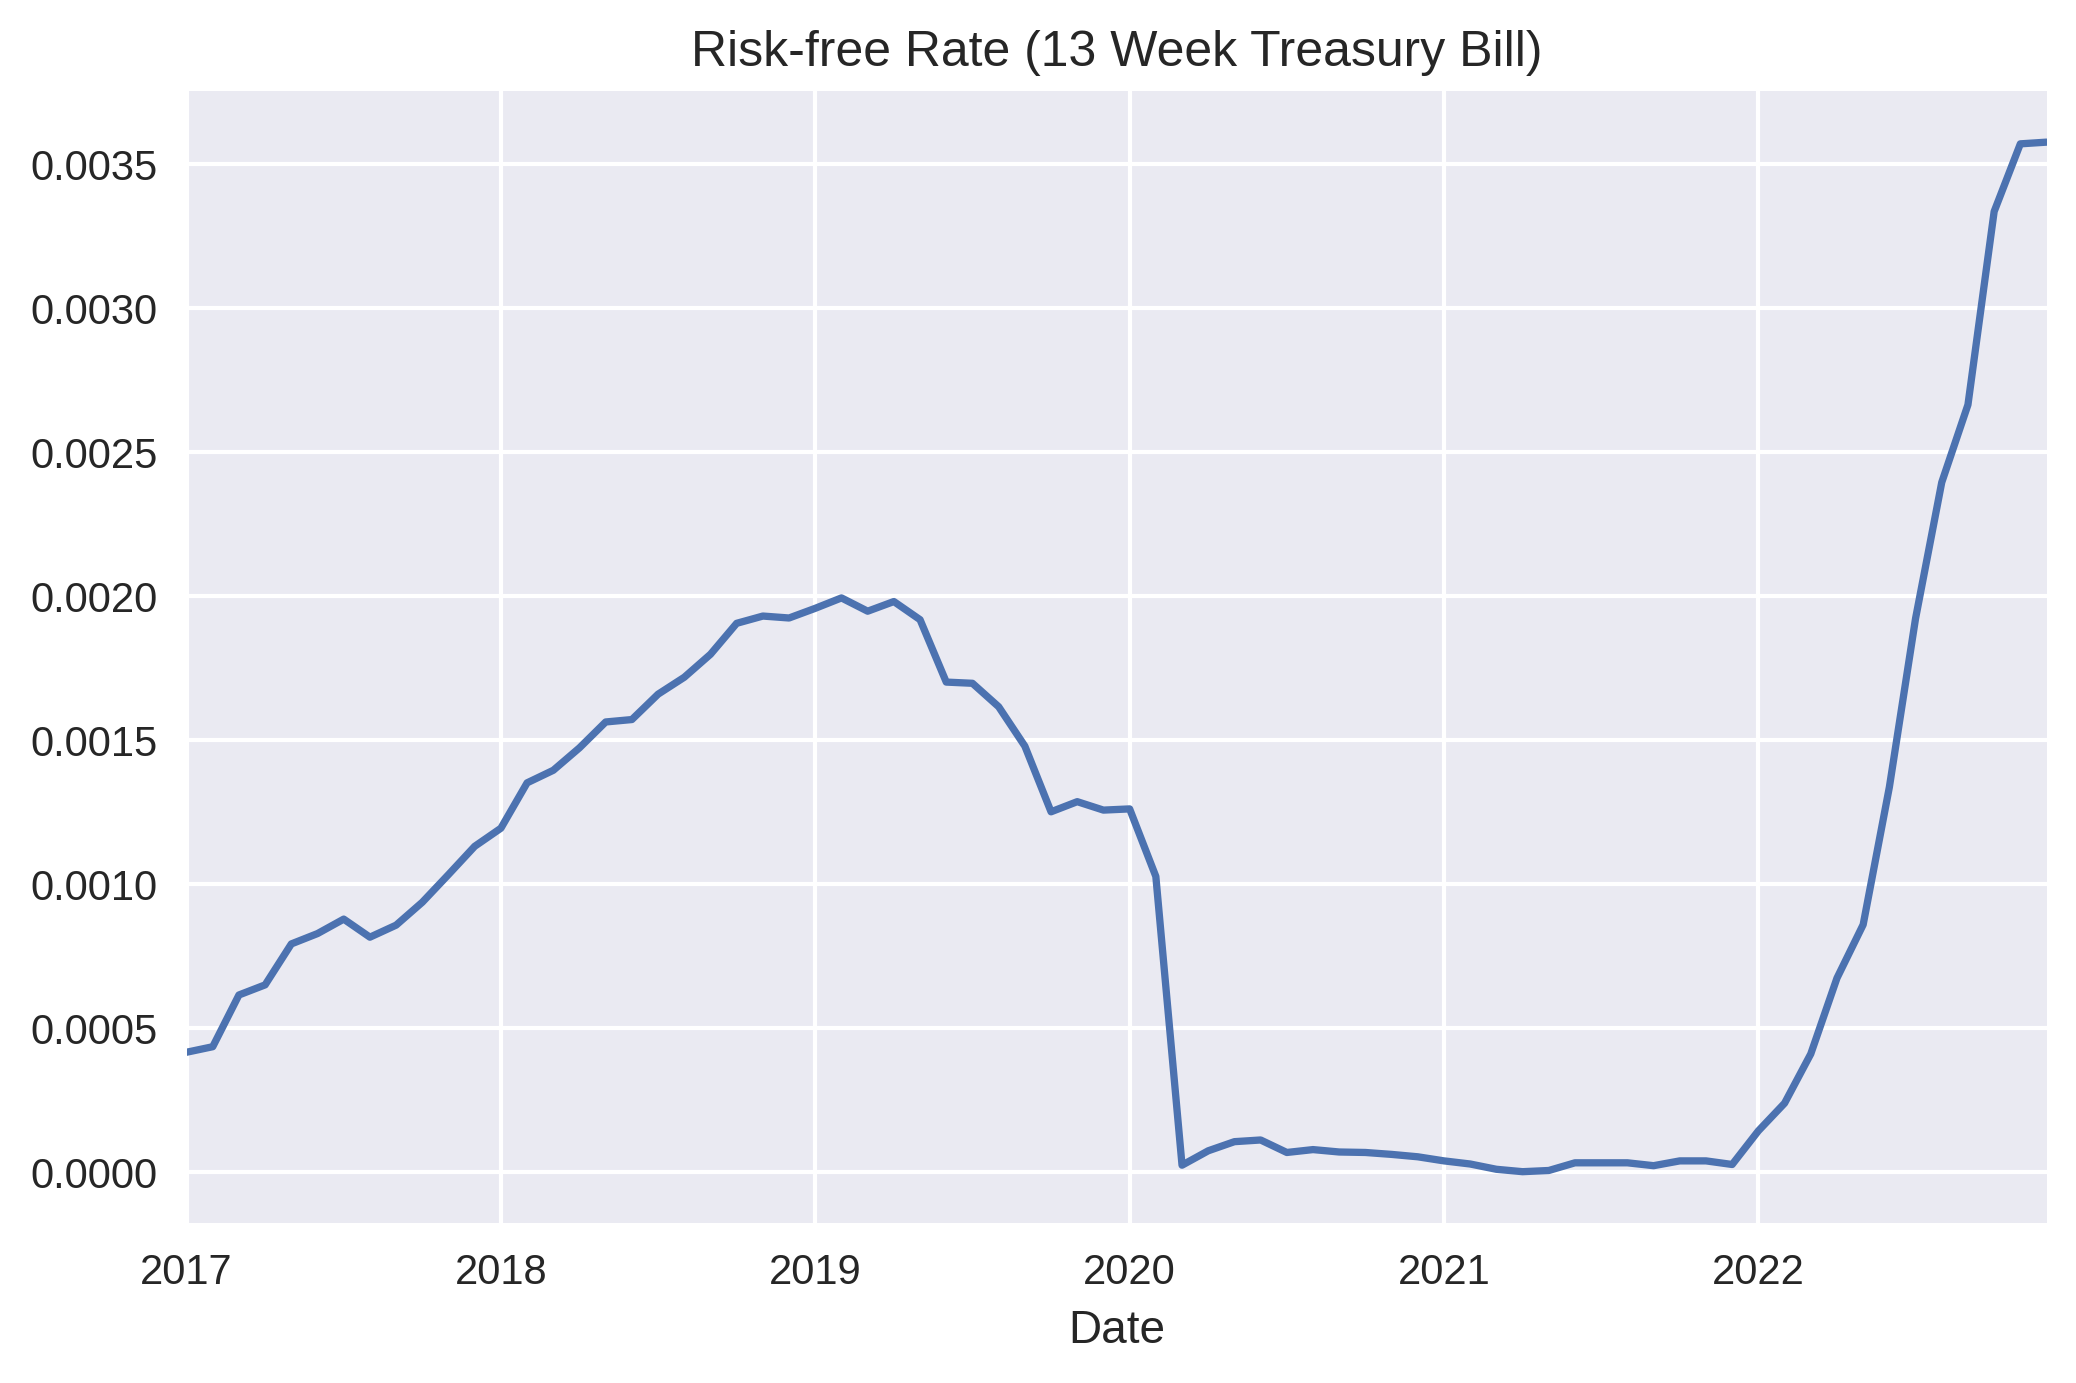

In [22]:
#plot the risk free rate
rf.plot(title='Risk-free Rate (13 Week Treasury Bill)')

In [23]:
#another approach is using 3-monthly treasury bills as risk free rate, download from FRED
import pandas_datareader.data as web

In [24]:
rf3m= web.DataReader('TB3MS', 'fred', start=startDate,end=endDate)

In [25]:
rf3m.head()

,TB3MS
DATE,
2017-01-01,0.51
2017-02-01,0.52
2017-03-01,0.74
2017-04-01,0.80
2017-05-01,0.89


In [26]:
#convert to monthly values
rf3m = (1 + (rf3m/100)) ** (1/12) - 1

<AxesSubplot:title={'center':'Risk-free Rate (3-Month Treasury Bill)'}, xlabel='DATE'>

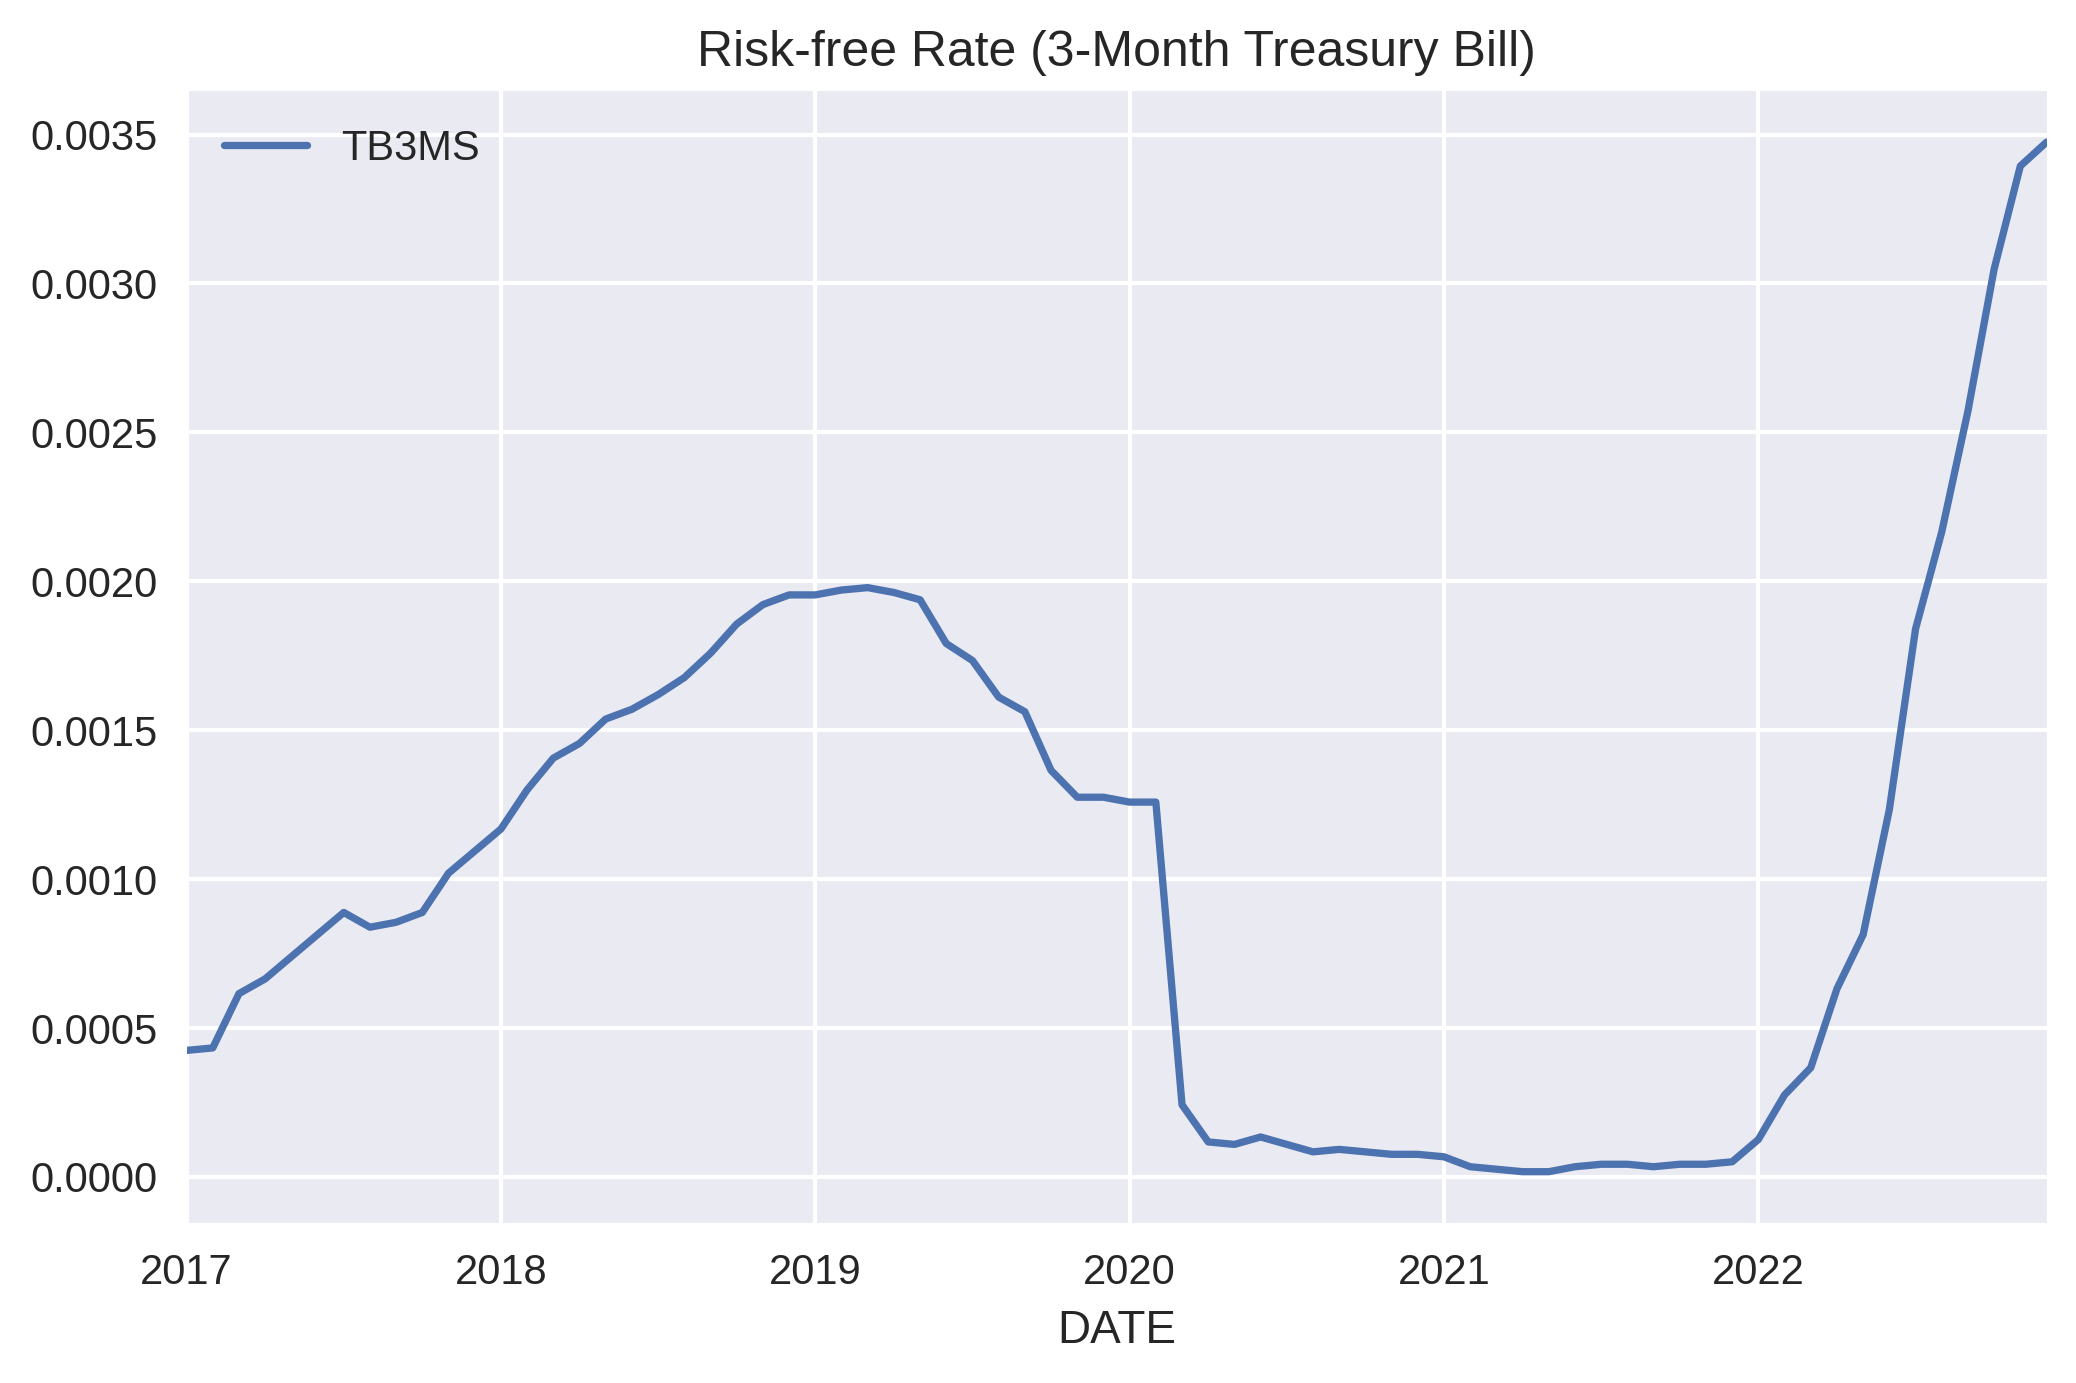

In [27]:
rf3m.plot(title='Risk-free Rate (3-Month Treasury Bill)')

- The two plots are similar.

## Fama-French Three Factors
- Model: $E(r_i)=r_f+ \alpha + \beta_{mkt}[E(r_m)-r_f]+\beta_{smb}SMB+\beta_{hml}HML$
  - Rewrite: $E(r_i)-r_f=\alpha + \beta_{mkt}MKT+\beta_{smb}SMB+\beta_{hml}HML$
  - Factors:
    - $MKT$: excess return of market
    - $SMB$: small minus big(size), the excess return of stocks with a small market cap over large market cap.
    - $HML$: high minus low(value), use `book-to-market ratio` as indicator, the excess return of value stocks over growth stocks.
    - $\beta_{mkt}$, $\beta_{smb}$, $\beta_{hml}$: factor exposure
    - $\alpha$: intercept
- BM and Market Cap Ranking

||High      | Middle| Low|
| :-------- | :--------  | :-----  | :-----: |
|**Small**| S/H| S/M|S/L|
| **Big**|B/H|B/M | B/L|

- Factor Construction:
  - Use NYSE, S&P500, or other index's market cap median(**50%**) as threshold, separate stocks as small and big.
  - Use NYSE, S&P500, or other index's BM **30%** and **70%** as thresholds, separate stocks as low, middle,and high.
  - $SMB=1/3(S/H+S/M+S/L)-1/3(B/H+B/M+B/L)$ 等权平均
  - $HML=1/2(S/H+B/H)-1/2(S/L+B/L)$

In this case, we use Meta monthly stock prices from 2017-2022 to estimate Fama-French three factor model.

In [1]:
import statsmodels.formula.api as smf

In [2]:
#download data from French's website with shell commend
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
!unzip -a F-F_Research_Data_Factors_CSV.zip
!rm F-F_Research_Data_Factors_CSV.zip

--2023-03-06 00:35:15--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.136.60
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.136.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12681 (12K) [application/x-zip-compressed]
Saving to: ‘F-F_Research_Data_Factors_CSV.zip’

F-F_Research_Data_F 100%[===================>]  12.38K  --.-KB/s    in 0s      

2023-03-06 00:35:15 (225 MB/s) - ‘F-F_Research_Data_Factors_CSV.zip’ saved [12681/12681]

Archive:  F-F_Research_Data_Factors_CSV.zip
  inflating: F-F_Research_Data_Factors.CSV  [binary]


In [15]:
#define the variables
risky_asset='META'
SD = '2016-12-31' #to avoid starting NaN after calculation
ED= '2022-12-31'

In [16]:
#data preprocessing, read the csv file, keep the last day of each month data
factor=pd.read_csv('/content/F-F_Research_Data_Factors.CSV',skiprows=3) #skip reading inefficient rows
#identify where the annual data starts
str_to_match = ' Annual Factors: January-December '
indices = factor.iloc[:, 0] == str_to_match
start_of_annual = factor[indices].index[0]
factor = factor[factor.index < start_of_annual]

In [17]:
factor.head()

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [18]:
#rename the columns, set index, and select the investment periods by datetime
factor.columns=['date','mkt','smb','hml','rf']
factor['date'] = pd.to_datetime(factor['date'], format='%Y%m').dt.strftime("%Y-%m")
factor = factor.set_index('date')
factor = factor.loc[SD:ED]

In [19]:
factor.head()

,mkt,smb,hml,rf
date,,,,
2017-01,1.94,-1.14,-2.76,0.04
2017-02,3.57,-2.02,-1.68,0.04
2017-03,0.17,1.14,-3.32,0.03
2017-04,1.09,0.72,-2.10,0.05
2017-05,1.06,-2.52,-3.78,0.06


In [20]:
factor.tail()

,mkt,smb,hml,rf
date,,,,
2022-08,-3.77,1.37,0.30,0.19
2022-09,-9.35,-0.79,0.06,0.19
2022-10,7.83,0.09,8.05,0.23
2022-11,4.60,-3.40,1.38,0.29
2022-12,-6.41,-0.68,1.32,0.33


In [21]:
#convert prices into numeric values and divide by 100 change to percentage 
factor=factor.apply(pd.to_numeric,errors='coerce').div(100) #errors='coerce' will replace all non-numeric values with NaN.

In [22]:
factor.head()

,mkt,smb,hml,rf
date,,,,
2017-01,0.0194,-0.0114,-0.0276,0.0004
2017-02,0.0357,-0.0202,-0.0168,0.0004
2017-03,0.0017,0.0114,-0.0332,0.0003
2017-04,0.0109,0.0072,-0.0210,0.0005
2017-05,0.0106,-0.0252,-0.0378,0.0006


In [23]:
#download data of risky asset
meta=yf.download(risky_asset,start=SD,end=ED,progress=False)

In [24]:
meta.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,116.029999,117.839996,115.510002,116.860001,116.860001,20663900
2017-01-04,117.550003,119.660004,117.290001,118.690002,118.690002,19630900
2017-01-05,118.860001,120.949997,118.320000,120.669998,120.669998,19492200
2017-01-06,120.980003,123.879997,120.029999,123.410004,123.410004,28545300
2017-01-09,123.550003,125.430000,123.040001,124.900002,124.900002,22880400


In [25]:
#data preprocessing, only keep the last day of each month, calculate the monthly simple return, drop missing value, format the index
y = meta['Adj Close'].resample('M').last().pct_change().dropna()
y.index = y.index.strftime('%Y-%m')
y.name = 'simple_return'

In [26]:
y.head()

Date
2017-02    0.040055
2017-03    0.048030
2017-04    0.057726
2017-05    0.008053
2017-06   -0.003169
Name: simple_return, dtype: float64

In [27]:
#merge the datasets and calculate excess return
dataset=factor.join(y)
dataset['excess_return']=dataset.simple_return-dataset.rf

In [28]:
dataset.head()

,mkt,smb,hml,rf,simple_return,excess_return
date,,,,,,
2017-01,0.0194,-0.0114,-0.0276,0.0004,NaN,NaN
2017-02,0.0357,-0.0202,-0.0168,0.0004,0.040055,0.039655
2017-03,0.0017,0.0114,-0.0332,0.0003,0.048030,0.047730
2017-04,0.0109,0.0072,-0.0210,0.0005,0.057726,0.057226
2017-05,0.0106,-0.0252,-0.0378,0.0006,0.008053,0.007453


In [29]:
#modeling with OLS for FF3
ff3 = smf.ols(formula='excess_return ~ mkt + smb + hml', data=dataset).fit()
ff3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     11.38
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           4.01e-06
Time:                        01:09:40   Log-Likelihood:                 74.737
No. Observations:                  71   AIC:                            -141.5
Df Residuals:                      67   BIC:                            -132.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0081      0.011     -0.773      0.442      -0.029       0.013
mkt            1.1944      0.209      5.709      0.000       0.777       1.612
smb           -0.5597      0.406     -1.379      0.172      -1.370       0.250
hml           -0.3789      0.251     -1.512      0.135      -0.879       0.121
==============================================================================
Omnibus:                       31.091   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.052
Skew:                          -1.274   Prob(JB):                     1.39e-21
Kurtosis:                       8.097   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Results Interpretation
  - the interception is negative and statistically significant at 5% significant level
  - mkt is statistically significant. The MKT factor gains the same direction matching the past results and our assumption.
  - While, smb and hml are both nonsignificant.
  - $H_0$: all betas=0
  - The prob of F-statistic= 0.00000401 is the corresponding p-value, telling the overall significance of regression, which give us the reason to **reject H0**.

#### Rolling FF3 on Portfolio of Assets
- consider an estimation window of a constant size (12 months set in this case), to test the <u>stability</u> of the results.
- Simple Asset Allocation of the Portfolio:
  - Equal weighted 
  - Amazon, Google, Apple, and Microsoft
  - use the monthly stock prices from 2017-2022

In [30]:
import pandas_datareader.data as web

In [68]:
port = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
W = [0.25, 0.25, 0.25, 0.25]
SD = '2017-12-31'
ED = '2022-12-31'

In [69]:
#download the factor related data from French website, change the unit, and set index
three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=SD)[0]
three_factor = three_factor.apply(pd.to_numeric,errors='coerce').div(100)
three_factor.index = three_factor.index.format()

In [70]:
three_factor.head()

,Mkt-RF,SMB,HML,RF
2017-12,0.0106,-0.0132,0.0005,0.0009
2018-01,0.0557,-0.0315,-0.0133,0.0012
2018-02,-0.0365,0.0023,-0.0107,0.0011
2018-03,-0.0235,0.0405,-0.0023,0.0011
2018-04,0.0028,0.0114,0.0054,0.0014


In [71]:
#download the portfolio related data
portfolio = yf.download(port,start=SD,end=ED,progress=False)

In [72]:
portfolio.head()

Adj Close                                       Close             \
                 AAPL       AMZN       GOOG       MSFT       AAPL       AMZN   
Date                                                                           
2018-01-02  40.888065  59.450500  53.250000  80.738167  43.064999  59.450500   
2018-01-03  40.880943  60.209999  54.124001  81.113907  43.057499  60.209999   
2018-01-04  41.070831  60.479500  54.320000  81.827843  43.257500  60.479500   
2018-01-05  41.538437  61.457001  55.111500  82.842331  43.750000  61.457001   
2018-01-08  41.384163  62.343498  55.347000  82.926872  43.587502  62.343498   

                                       High             ...        Low  \
                 GOOG       MSFT       AAPL       AMZN  ...       GOOG   
Date                                                    ...              
2018-01-02  53.250000  85.949997  43.075001  59.500000  ...  52.261501   
2018-01-03  54.124001  86.349998  43.637501  60.274502  ...  53.160500   
2018-01-04  54.320000  87.110001  43.367500  60.793499  ...  54.200100   
2018-01-05  55.111500  88.190002  43.842499  61.457001  ...  54.599998   
2018-01-08  55.347000  88.279999  43.902500  62.653999  ...  55.081001   

                            Open                                      Volume  \
                 MSFT       AAPL       AMZN       GOOG       MSFT       AAPL   
Date                                                                           
2018-01-02  85.500000  42.540001  58.599998  52.417000  86.129997  102223600   
2018-01-03  85.970001  43.132500  59.415001  53.215500  86.059998  118071600   
2018-01-04  86.570000  43.134998  60.250000  54.400002  86.589996   89738400   
2018-01-05  87.430000  43.360001  60.875500  54.700001  87.660004   94640000   
2018-01-08  87.599998  43.587502  61.799999  55.111500  88.199997   82271200   

                                          
                AMZN      GOOG      MSFT  
Date                                      
2018-01-02  53890000  24752000  22483800  
2018-01-03  62176000  28604000  26061400  
2018-01-04  60442000  20092000  21912000  
2018-01-05  70894000  25582000  23407100  
2018-01-08  85590000  20952000  22113000  

[5 rows x 24 columns]

In [73]:
#calculate the monthly simple return data
portfolio = portfolio['Adj Close'].resample('M').last().pct_change().dropna().apply(pd.to_numeric,errors='coerce')
portfolio.index = portfolio.index.strftime('%Y-%m')

In [74]:
portfolio.head()

,AAPL,AMZN,GOOG,MSFT
Date,,,,
2018-02,0.068185,0.042429,-0.055738,-0.008415
2018-03,-0.058051,-0.043049,-0.066025,-0.026661
2018-04,-0.015020,0.082075,-0.014014,0.024652
2018-05,0.135124,0.040539,0.066507,0.061467
2018-06,-0.009418,0.043065,0.028258,-0.002327


In [75]:
#use individual return weighted average to get portfolio return
portfolio['portfolio_returns'] = np.matmul(portfolio[port].values, W) #get the matrix multiplication

In [76]:
portfolio.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2018-02,0.068185,0.042429,-0.055738,-0.008415,0.011615
2018-03,-0.058051,-0.043049,-0.066025,-0.026661,-0.048447
2018-04,-0.015020,0.082075,-0.014014,0.024652,0.019423
2018-05,0.135124,0.040539,0.066507,0.061467,0.075909
2018-06,-0.009418,0.043065,0.028258,-0.002327,0.014895


<AxesSubplot:xlabel='Date'>

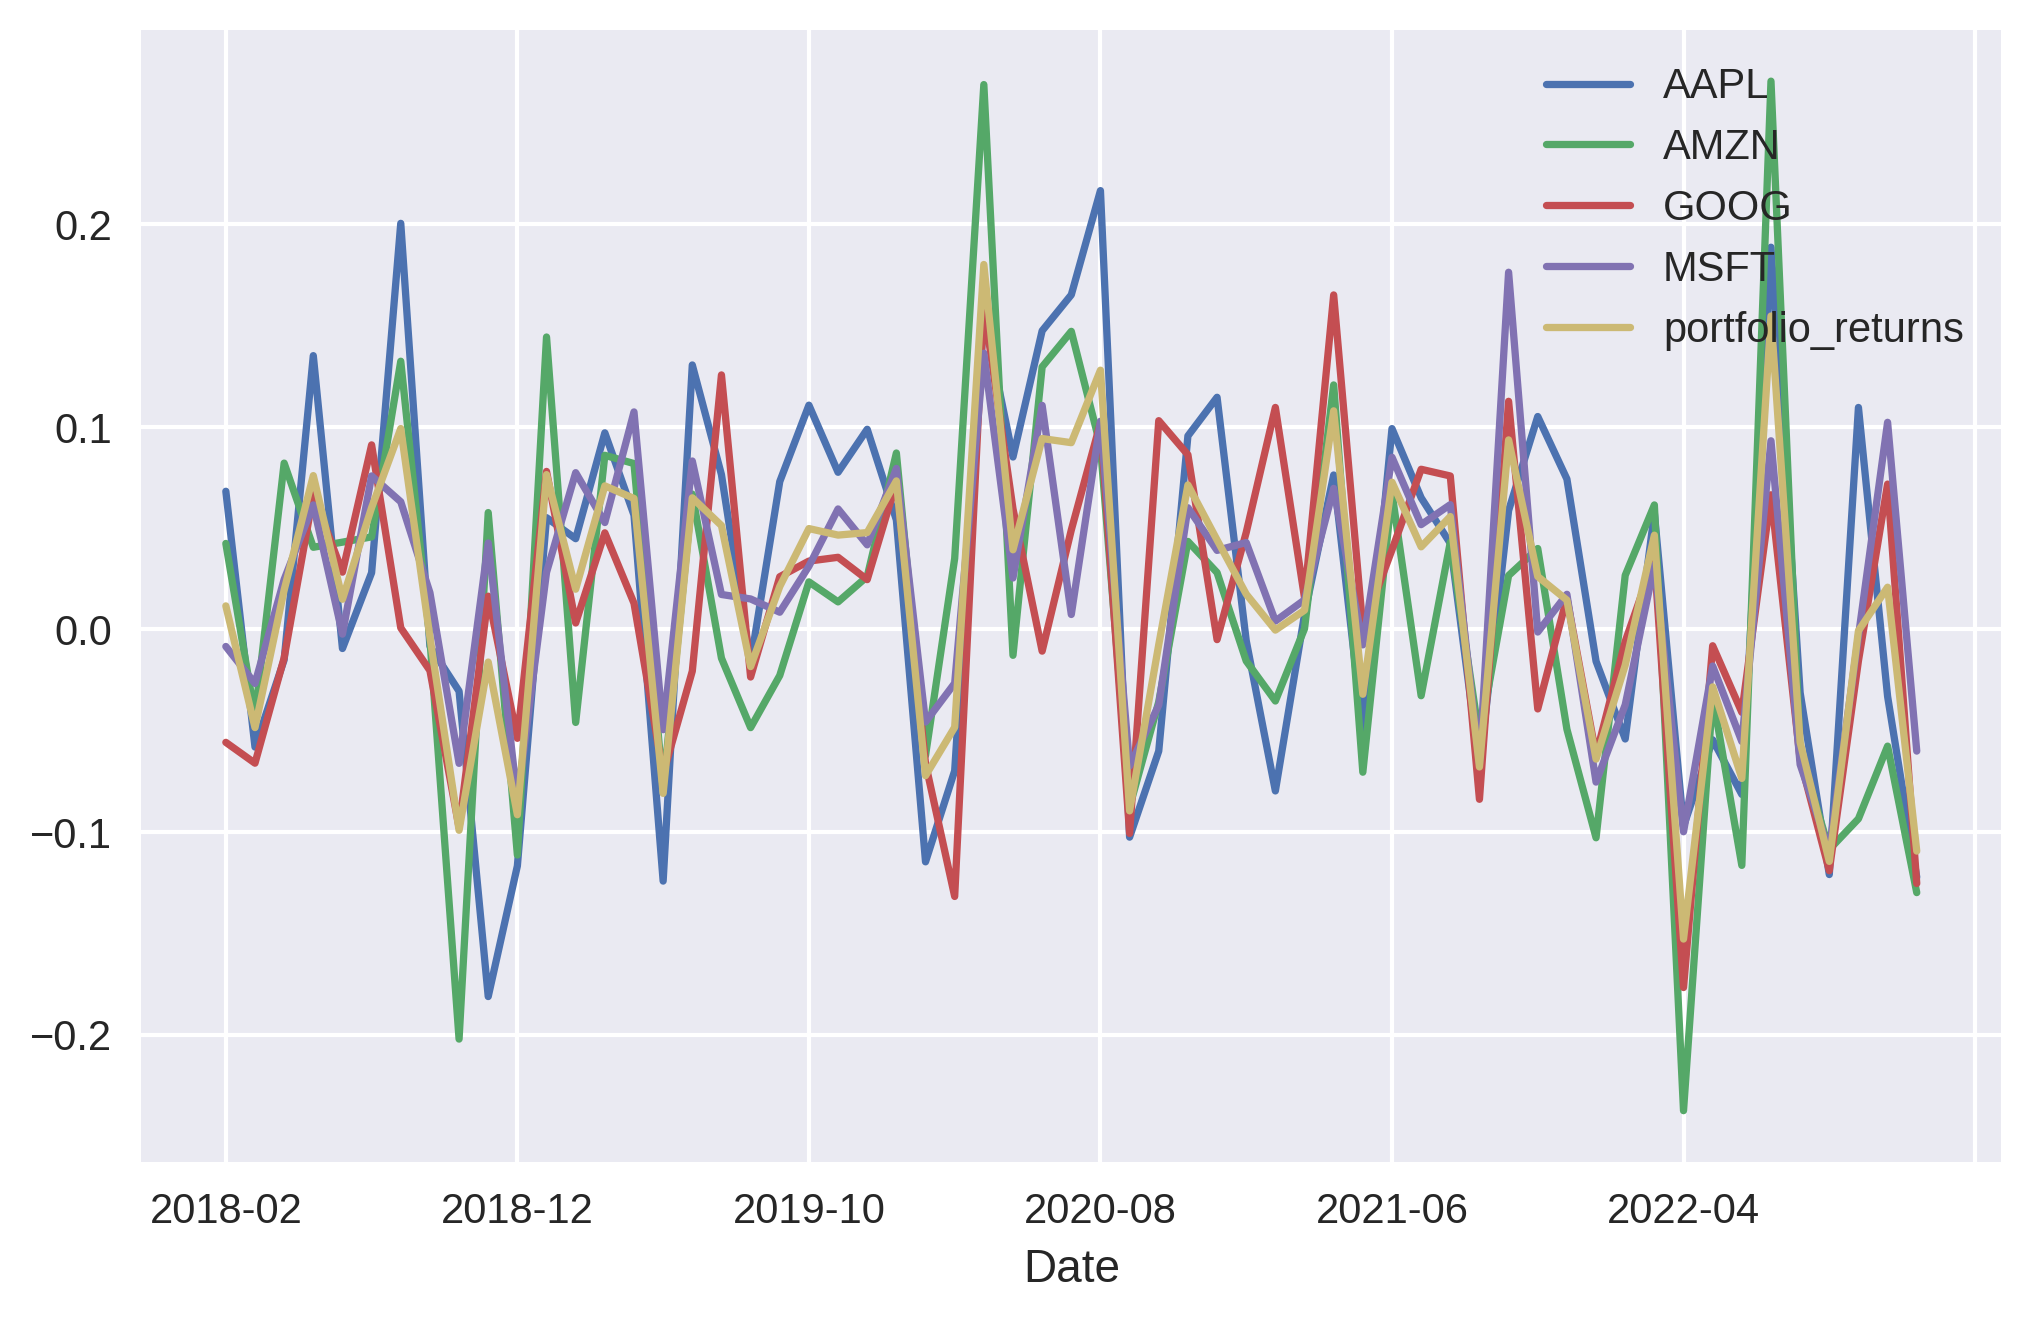

In [87]:
portfolio.plot()

In [95]:
#merge the portfolio dataset and benchmark data from French website
dataset1 = portfolio.join(three_factor).drop(port, axis=1)
dataset1.columns = ['portf_return', 'mkt', 'smb', 'hml', 'rf'] #rename
dataset1['portf_excess_return'] = dataset1.portf_return - dataset.rf

In [96]:
dataset1.head()

,portf_return,mkt,smb,hml,rf,portf_excess_return
Date,,,,,,
2018-02,0.011615,-0.0365,0.0023,-0.0107,0.0011,0.011615
2018-03,-0.048447,-0.0235,0.0405,-0.0023,0.0011,-0.048447
2018-04,0.019423,0.0028,0.0114,0.0054,0.0014,0.019423
2018-05,0.075909,0.0265,0.0526,-0.0318,0.0014,0.075909
2018-06,0.014895,0.0048,0.0115,-0.0233,0.0014,0.014895


In [97]:
print(dataset1[dataset1.isna().any(axis=1)])

Empty DataFrame
Columns: [portf_return, mkt, smb, hml, rf, portf_excess_return]
Index: []


In [98]:
print(dataset1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, 2018-02 to 2022-12
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   portf_return         59 non-null     float64
 1   mkt                  59 non-null     float64
 2   smb                  59 non-null     float64
 3   hml                  59 non-null     float64
 4   rf                   59 non-null     float64
 5   portf_excess_return  59 non-null     float64
dtypes: float64(6)
memory usage: 5.3+ KB
None


In [99]:
#rolling functions
def rolling_factor_model(input_data, formula, window_size):
    coeffs = []
    #define and fit the ols regression model
    #set the rolling start and end index with fixed time period 
    for start_index in range(len(input_data) - window_size + 1): 
        end_index = start_index + window_size
        #use the rolling window in formula
        FF3 = smf.ols(formula=formula,data=input_data[start_index:end_index]).fit()
        #store coefficients
        coeffs.append(FF3.params)

    coefficient = pd.DataFrame(coeffs, index=input_data.index[window_size - 1:]) #contains intercept and 3 factors

    return coefficient

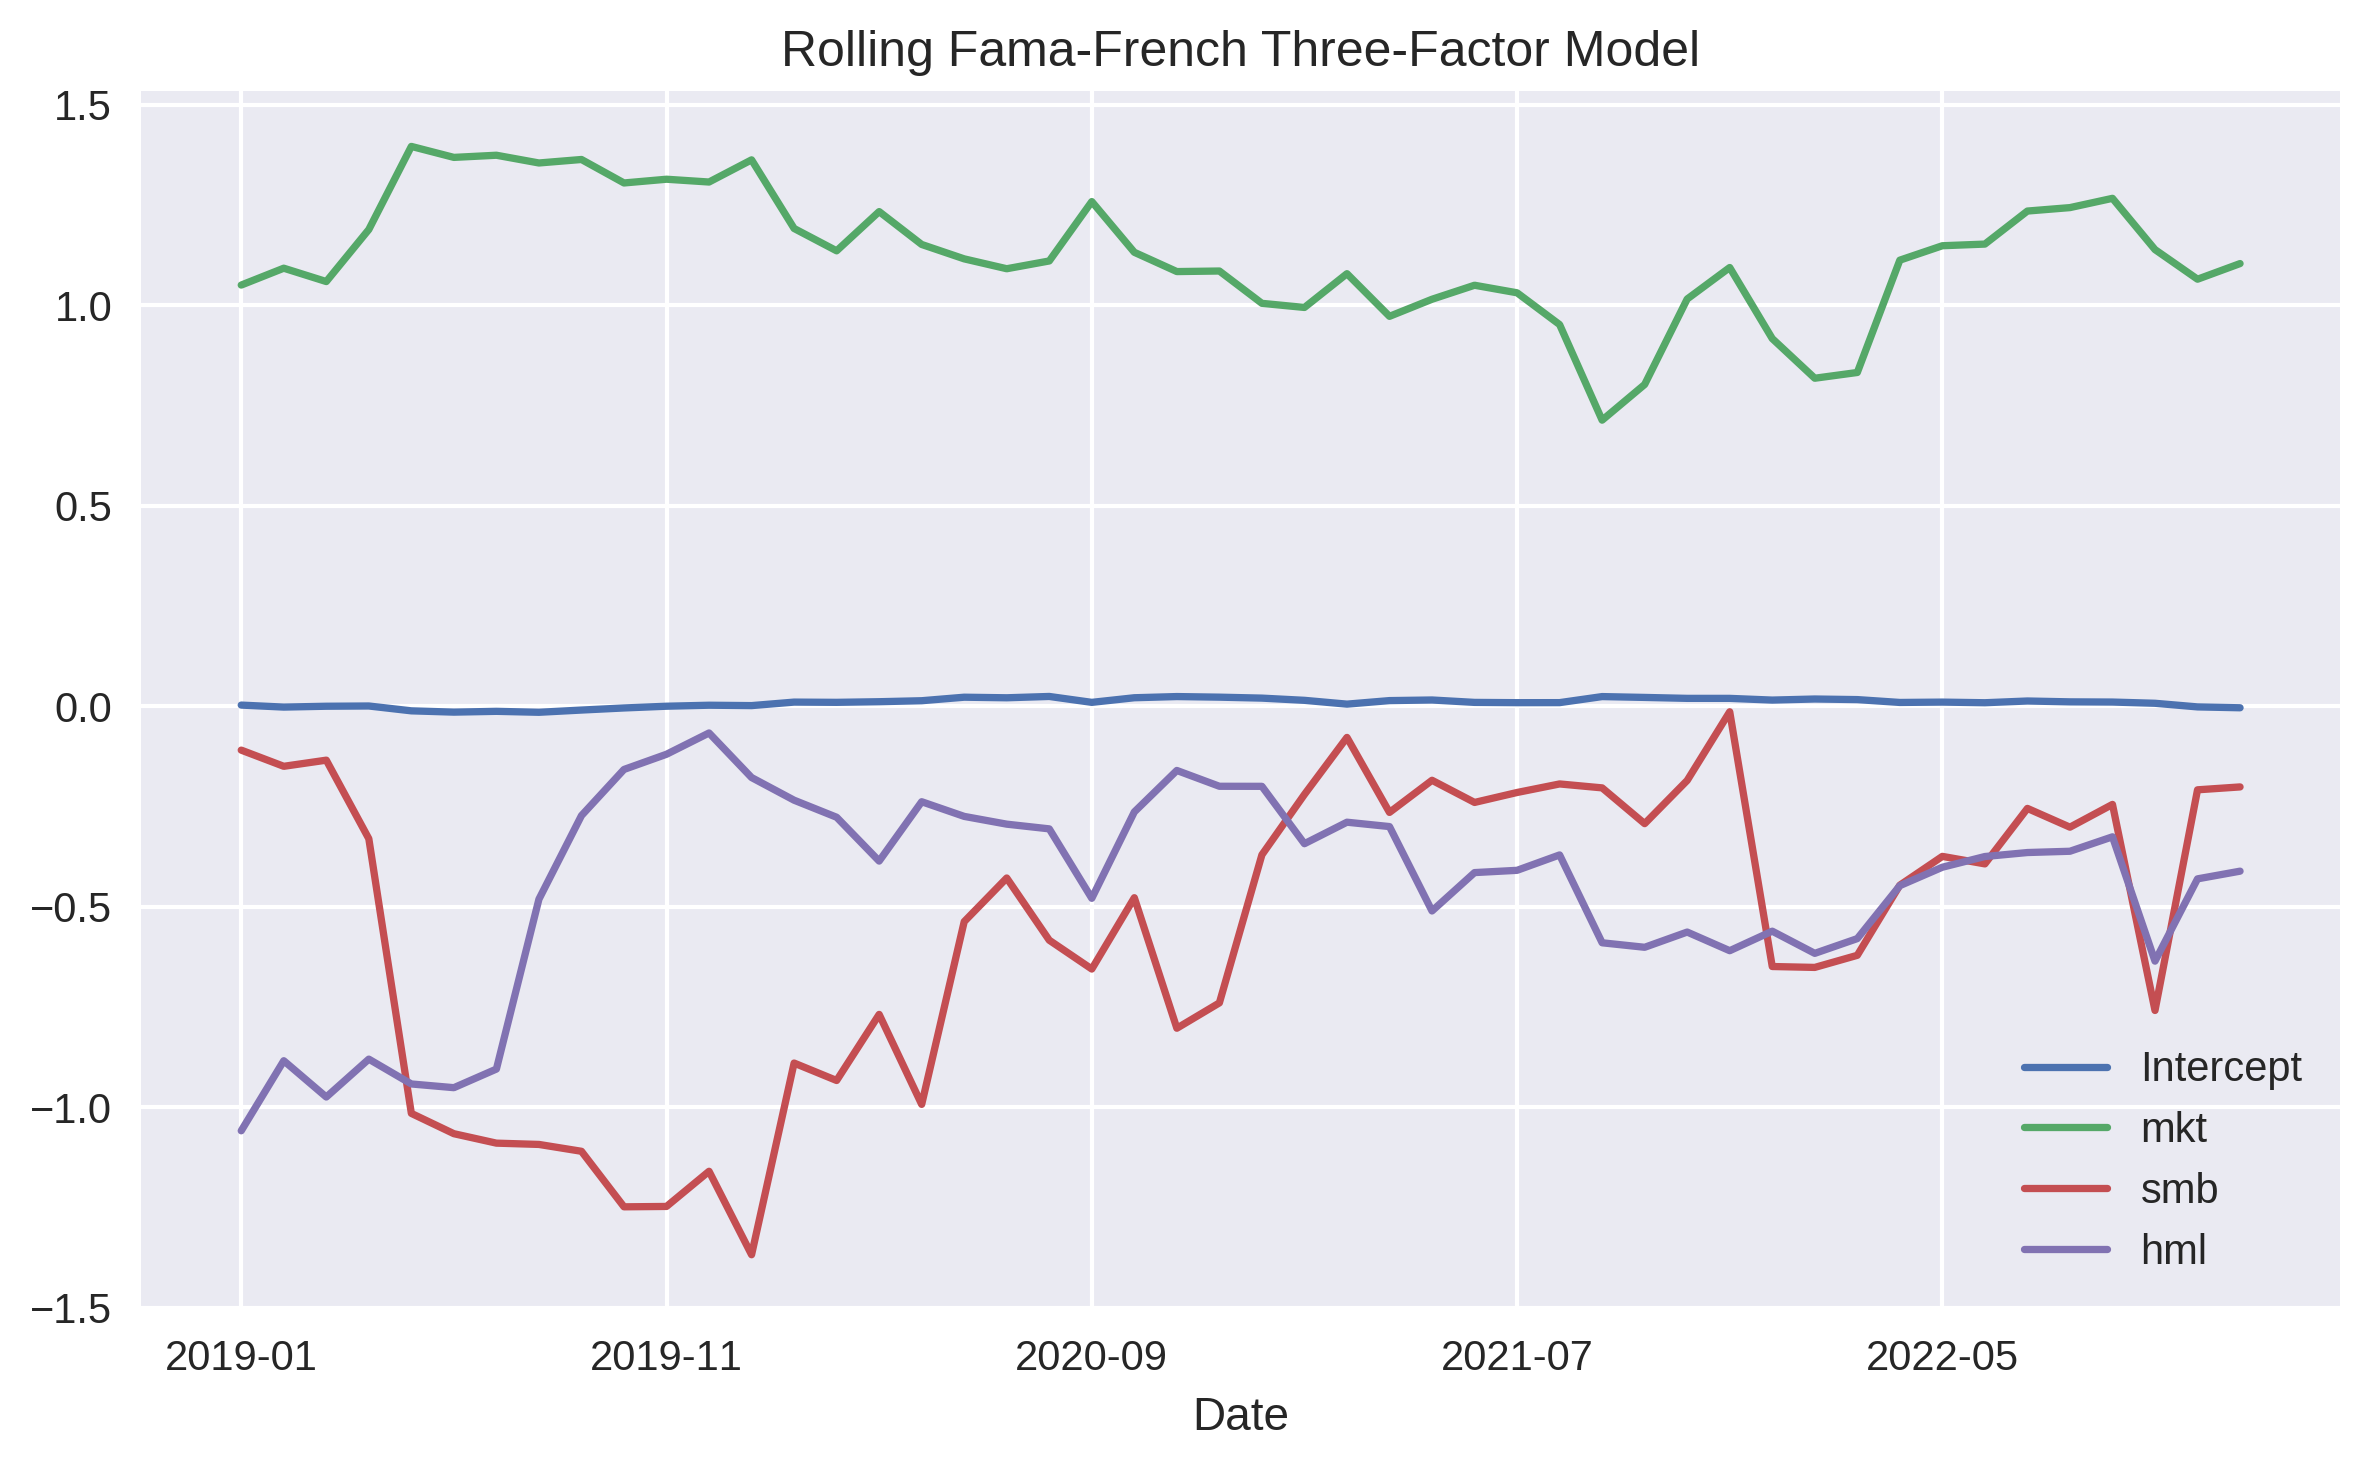

In [103]:
FF3R = 'portf_excess_return ~ mkt + smb + hml'
results= rolling_factor_model(dataset1, FF3R, window_size=12)
results.plot(title = 'Rolling Fama-French Three-Factor Model')
plt.tight_layout()
plt.show()

- The intercept is almost around 0.

## Carhart Four Factors
- Formula: $E(r_i)-r_f=\alpha + \beta_{mkt}MKT+\beta_{smb}SMB+\beta_{hml}HML+\beta_{mom}MOM$
  - $MOM$ or $WML$: momentum factor, winner minus loser. The excess returns of the winner stocks over the loser stocks in the past 12 months
    - Assumption: in the short term, a winner stock will remain a winner, while a loser will remain a loser.
    - Threshold and classification: use last `12-month cumulative total returns` as indicator, ranking Top30% as winner, Tail30% as loser.
    - Long the winners, and short the losers.
- Model Optimization: 
  - only use data from t-12 to t-1(11months in total), for avoiding reversal effect in short term to disturb momentum factor.

## Fama-French Five Factors
- Formula: $E(r_i)-r_f=\alpha + \beta_{mkt}MKT+\beta_{smb}SMB+\beta_{hml}HML+\beta_{rmw}RMW+\beta_{cma}CMA$
  - Factors:
    - $RMW$:Robust minus weak,the excess returns of companies with high profit margins (robust **profitability**) over those with lower profits (weak profitability).
    - $CMA$:conservative minus aggressive,  the excess returns of firms with low **investment policies** (conservative) over those investing more (aggressive).
- Ranking

1. ROE&MarketCap

||Robust     | Neutral| Weak|
| :-------- | :--------  | :-----  | :-----: |
|**Small**| S/R| S/N|S/W|
| **Big**|B/R|B/N | B/W|

2. Investment(∆BookValue)&Market Cap

||Aggressive    | Neutral| Conservation|
| :-------- | :--------  | :-----  | :-----: |
|**Small**| S/A| S/N|S/C|
| **Big**|B/A|B/N | B/C|

3. BM&Market Cap

||High      | Middle| Low|
| :-------- | :--------  | :-----  | :-----: |
|**Small**| S/H| S/M|S/L|
| **Big**|B/H|B/M | B/L|

- Factor Construction
  - $RMW=1/2(S/R+B/R)-1/2(S/W+B/W)$
  - $CMA=1/2(S/C+B/C)-1/2(S/A+B/A)$
  - $SMB=1/3(SMB_{BM}+SME_{ROE}+SMB_{INV})$
    - $SMB_{BM}=1/3(S/H+S/M+S/L)-1/3(B/H+B/M+B/L)$
    - $SMB_{ROE}=1/3(S/R+S/N+S/W)-1/3(B/R+B/N+B/W)$
    - $SMB_{INV}=1/3(S/C+S/N+S/A)-1/3(B/C+B/N+B/A)$
  - $HML=1/2(S/H+B/H)-1/2(S/L+B/L)$
- Other:
  - long-term expected profitability rate(r)↑,expected gross profit(Y)↑, expected investment(dB)↓
  - Threshold: 

|Threshold1|ROE      |Asset Change Rate| BM Ratio|Threshold2|Market Cap |
| :-------- | :--------  | :-----  | :----- |:----- |:-----: |
|**<30th%**| Weak| Conservation|High|**<50%**|Small|
| **>70th%**|Robust|Aggressive| Low|**>50%**|Big|

In this case, we use Amazon monthly returns from 2017 to 2022 with Four- and Five Factors modeling estimation.

In [83]:
riskyAsset = 'AMZN'
SD = '2017-12-31'
ED = '2022-12-31'

In [105]:
##download the risk factors from French Website
#three factor
three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=SD)[0]
three_factor.index = three_factor.index.format()
#momentum factor
mom=web.DataReader('F-F_Momentum_Factor', 'famafrench', start=SD)[0]
mom.index = mom.index.format()
#five factor
five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start=SD)[0]
five_factor.index = five_factor.index.format()

In [115]:
#download risky asset from yf
AMAZ = yf.download(riskyAsset,start=SD,end=ED,progress=False)

In [116]:
AMAZ.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000
2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000
2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000
2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000
2018-01-08,61.799999,62.653999,61.601501,62.343498,62.343498,85590000


In [117]:
#data processing,get data of last day of each month,and calculate the simple return
AMAZReturn = AMAZ['Adj Close'].resample('M').last().pct_change().dropna()
AMAZReturn.index = AMAZReturn.index.strftime('%Y-%m')
AMAZReturn.name = 'simple_return'

In [118]:
#merge datasets
four_factor = three_factor.join(mom).join(AMAZReturn)

In [119]:
four_factor.head()

,Mkt-RF,SMB,HML,RF,Mom,simple_return
2017-12,1.06,-1.32,0.05,0.09,-1.54,NaN
2018-01,5.57,-3.15,-1.33,0.12,4.05,NaN
2018-02,-3.65,0.23,-1.07,0.11,3.58,0.042429
2018-03,-2.35,4.05,-0.23,0.11,-1.13,-0.043049
2018-04,0.28,1.14,0.54,0.14,0.36,0.082075


In [120]:
#rename the columns
four_factor.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'simple_return']

In [121]:
#change into percentage except simple_return column
four_factor.loc[:, four_factor.columns != 'simple_return'] /= 100

In [122]:
four_factor.head()

,mkt,smb,hml,rf,mom,simple_return
2017-12,0.0106,-0.0132,0.0005,0.0009,-0.0154,NaN
2018-01,0.0557,-0.0315,-0.0133,0.0012,0.0405,NaN
2018-02,-0.0365,0.0023,-0.0107,0.0011,0.0358,0.042429
2018-03,-0.0235,0.0405,-0.0023,0.0011,-0.0113,-0.043049
2018-04,0.0028,0.0114,0.0054,0.0014,0.0036,0.082075


In [123]:
#set index
four_factor.index = [pd.to_datetime(x, format='%Y-%m') for x in four_factor.index]

In [124]:
#select time period we want
four_factor = four_factor.loc[SD:ED]

In [125]:
four_factor.head()

,mkt,smb,hml,rf,mom,simple_return
2018-01-01,0.0557,-0.0315,-0.0133,0.0012,0.0405,NaN
2018-02-01,-0.0365,0.0023,-0.0107,0.0011,0.0358,0.042429
2018-03-01,-0.0235,0.0405,-0.0023,0.0011,-0.0113,-0.043049
2018-04-01,0.0028,0.0114,0.0054,0.0014,0.0036,0.082075
2018-05-01,0.0265,0.0526,-0.0318,0.0014,0.0389,0.040539


In [126]:
four_factor.tail()

,mkt,smb,hml,rf,mom,simple_return
2022-08-01,-0.0377,0.0137,0.0030,0.0019,0.0199,-0.060615
2022-09-01,-0.0935,-0.0079,0.0006,0.0019,0.0347,-0.108622
2022-10-01,0.0783,0.0009,0.0805,0.0023,0.0387,-0.093451
2022-11-01,0.0460,-0.0340,0.0138,0.0029,-0.0201,-0.057595
2022-12-01,-0.0641,-0.0068,0.0132,0.0033,0.0452,-0.129894


In [135]:
#calculate mkt factor value
four_factor['excess_return'] = four_factor.simple_return - four_factor.rf

In [136]:
four_factor.head()

,mkt,smb,hml,rf,mom,simple_return,excess_rtn,excess_return
2018-01-01,0.0557,-0.0315,-0.0133,0.0012,0.0405,NaN,NaN,NaN
2018-02-01,-0.0365,0.0023,-0.0107,0.0011,0.0358,0.042429,0.041329,0.041329
2018-03-01,-0.0235,0.0405,-0.0023,0.0011,-0.0113,-0.043049,-0.044149,-0.044149
2018-04-01,0.0028,0.0114,0.0054,0.0014,0.0036,0.082075,0.080675,0.080675
2018-05-01,0.0265,0.0526,-0.0318,0.0014,0.0389,0.040539,0.039139,0.039139


In [131]:
#merge five factor data with risky asset return and data preprocessing 
five_factor = five_factor.join(AMAZReturn)
#data preprocessing, similar to four factor above
five_factor.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'simple_return']
five_factor.loc[:, five_factor.columns != 'rtn'] /= 100
five_factor.index = [pd.to_datetime(x, format='%Y-%m') for x in five_factor.index]
five_factor = five_factor.loc[SD:ED]
five_factor['excess_return'] = five_factor.simple_return - five_factor.rf
five_factor.head()

,mkt,smb,hml,rmw,cma,rf,simple_return,excess_return
2018-01-01,0.0557,-0.0320,-0.0133,-0.0073,-0.0101,0.0012,NaN,NaN
2018-02-01,-0.0365,0.0031,-0.0107,0.0054,-0.0239,0.0011,0.000424,-0.000676
2018-03-01,-0.0235,0.0358,-0.0023,-0.0045,0.0000,0.0011,-0.000430,-0.001530
2018-04-01,0.0028,0.0093,0.0054,-0.0243,0.0127,0.0014,0.000821,-0.000579
2018-05-01,0.0265,0.0474,-0.0318,-0.0205,-0.0147,0.0014,0.000405,-0.000995


In [138]:
#modeling for Four Factor
C4 = smf.ols(formula='excess_return ~ mkt + smb + hml + mom', data=four_factor).fit()
C4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     22.83
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           4.44e-11
Time:                        07:00:08   Log-Likelihood:                 84.815
No. Observations:                  59   AIC:                            -159.6
Df Residuals:                      54   BIC:                            -149.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0021      0.008     -0.269      0.789      -0.018       0.014
mkt            1.1915      0.164      7.248      0.000       0.862       1.521
smb           -0.0802      0.309     -0.260      0.796      -0.699       0.538
hml           -0.8726      0.193     -4.519      0.000      -1.260      -0.485
mom           -0.0241      0.240     -0.101      0.920      -0.506       0.457
==============================================================================
Omnibus:                        1.504   Durbin-Watson:                   2.227
Prob(Omnibus):                  0.472   Jarque-Bera (JB):                1.181
Skew:                          -0.114   Prob(JB):                        0.554
Kurtosis:                       2.345   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
#modeling for five factor
FF5 = smf.ols(formula='excess_return ~ mkt + smb + hml + rmw + cma', data=five_factor).fit()
FF5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     6.281
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           0.000121
Time:                        06:59:44   Log-Likelihood:                 317.43
No. Observations:                  59   AIC:                            -622.9
Df Residuals:                      53   BIC:                            -610.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0009      0.000     -5.795      0.000      -0.001      -0.001
mkt            0.0137      0.003      4.165      0.000       0.007       0.020
smb        -6.839e-05      0.007     -0.010      0.992      -0.014       0.014
hml           -0.0025      0.005     -0.458      0.649      -0.013       0.008
rmw           -0.0014      0.008     -0.174      0.863      -0.017       0.015
cma           -0.0082      0.008     -1.011      0.317      -0.024       0.008
==============================================================================
Omnibus:                        1.303   Durbin-Watson:                   0.622
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.307
Skew:                          -0.331   Prob(JB):                        0.520
Kurtosis:                       2.694   Cond. No.                         68.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Novy-Marx Four Factors
- Formula: $E(r_i)-r_f=\alpha + \beta_{mkt}MKT+\beta_{umd}UMD+\beta_{hml}HML+\beta_{pmu}PMU$
  - Factors:
    - $UMD$: up minus down, a momentum factor相当于Carhart four factor里的MOM
    - $PMU$: profitability minus unporfitability, indicator:gross profit to asset ratio
- Ranking: Gross Profitability and Market Cap

||Profitable    | Neutral| Unprofitable|
| :-------- | :--------  | :-----  | :-----: |
|**Small**| S/P| S/N|S/U|
| **Big**|B/P|B/N | B/U|

- Factor Construction:
  - Industry Neutral
  - threshold: top30%, tail30%
  - $PMU=1/2(S/P+B/P)-1/2(S/U+B/U)$, positive correlation between gross profit and expected return.

## Stambaugh-Yuan Four Factors
- Add factors from behavior finance
- Formula: $E(R_i)-R_f=\alpha + \beta_{mkt}(E[R_M]-R_f)+\beta_{smb}E[R_{SMB}]+\beta_{mgmt}E[R_{MGMT}]+\beta_{pref}E[R_{PREF}]$
  - $MGMT$: mispricing(deviate from intrinsic value) result from management
  - $PREF$: mispricing result from preformance
- Anomaly: the mispricing indicators
**MGMT** Group

|Indicator| Correlation with Expected Return| 
| :-------- | :--------:| 
| Net Stock Issue|N|
|Composite Equity Issues|N | 
| Accruals|N|
|Net operating assets|N | 
| Asset Growth|N|
|Investment to Asset|N | 

**PREF** Group

|Indicator| Correlation with Expected Return| 
| :-------- | :--------:| 
| Distress|N|
|O-Score|N | 
| Momentum|P|
|Gross Profitability|P | 
| Return on Asset|P|

- O-score:  9 different approximate measures linear combination with weighted average of a firm's default risk
  - Calculation:
  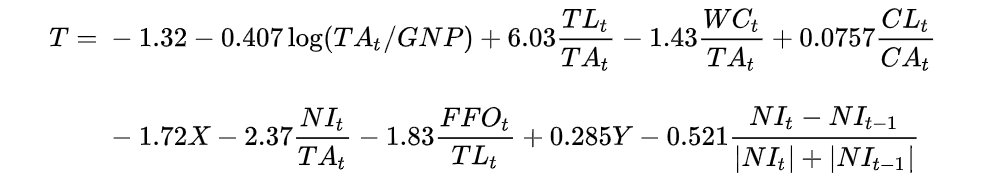
  - TA: total asset
  - TL: total liability
  - WC: working capital
  - CL: current liability
  - CA: current asset
  - NI: net income
  - FFO: fund from operation
  - GNP: gross national product price index level 
  - X: binary indicator=1, if TA< TL
  - Y: binary indicator=1,if there is a net loss for last 2 years

- Ranking:
1. Management and Market Cap

||High    | Middle| Low|
| :-------- | :--------  | :-----  | :-----: |
|**Small**| S/H| S/M|S/L|
| **Big**|B/H|B/M | B/L|

2. Performance and Market Cap

||High    | Middle| Low|
| :-------- | :--------  | :-----  | :-----: |
|**Small**| S/H| S/M|S/L|
| **Big**|B/H|B/M | B/L|

- Threshold: top20%, tail20% for all stocks

- Factor Construction:
  - $MGMT=1/2(S/L+B/L)-1/2(S/H+B/H)$
  - $PREF=1/2(S/L+B/L)-1/2(S/H+B/H)$
  - $SMB=1/2(S/M_{MGMT}-S/M_{PREF})-1/2(B/M_{MGMT}-B/M_{PREF})$
    - Double sorting method

## Daniel-Hirshleifer-Sun Three Factors

### $q^4$ and $q^5$ Model